<a href="https://colab.research.google.com/github/CanopySimulations/canopy-python-examples/blob/master/finding_quickest_5_seconds_to_apply_power_increase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upgrade Runtime
This cell ensures the runtime supports `asyncio` async/await, and is needed on Google Colab. If the runtime is upgraded, you will be prompted to restart it, which you should do before continuing execution.

In [0]:
!pip install "ipython>=7"

# Set Up Environment

### Import required libraries

In [0]:
!pip install -q 'canopy==8.0'

In [0]:
import canopy
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

from typing import List, Tuple, NamedTuple

logging.basicConfig(level=logging.INFO)

### Authenticate

In [0]:
authentication_data = canopy.prompt_for_authentication()

def create_session():
    return canopy.Session(authentication_data)

# Set Up Example

**NOTE:**
 - If you would like to run a new SLS study, set `existing_study_id` to `None`. Running a new study will take several minutes.

 - If you would like to load an existing Dynamic Lap SLS study instead, set `existing_study_id` to the ID of the study in your account.

In [0]:
existing_study_id = None

In [108]:
async def create_new_study():
    async with create_session() as session:
        logging.info('Loading study inputs...')

        car = await canopy.load_default_config(session, 'car', 'Canopy F1 Car 2019')
        weather = await canopy.load_default_config(session, 'weather', '25 deg, dry')
        track = await canopy.load_default_config(session, 'track', 'Barcelona-F1')

        logging.info('Submitting study...')

        study_id = await canopy.create_study(
            session,
            'dynamicLapWithSLS',
            'Example SLS Study',
            [ car, weather, track ])

        logging.info('Waiting for study...')

        await canopy.wait_for_study(
            session,
            study_id,
            timeout_seconds=900)
        
        return study_id

if existing_study_id is not None:
    study_id = existing_study_id
else:
    study_id = await create_new_study()

logging.info(f'Using study {study_id}')

INFO:root:Loading study inputs...
INFO:root:Submitting study...
INFO:root:Waiting for study...
INFO:root:Using study c334db9118404e0f9751a65253ced3c6


# Example: Finding the quickest 5 seconds to apply a power increase.

Using the `dTLap_drEnginePowerFactor` channel we will find the sLap ranges representing the optimal places to deploy 5 seconds of power increase.

## Create Helper Functions

This function will return the total time the target column is over a threshold, and the tLap and sLap ranges where that occurs:

In [0]:
class SecondsOverThresholdResult(NamedTuple):
    tLap_total: float
    tLap_ranges: List[Tuple[float, float]]
    sLap_ranges: List[Tuple[float, float]]

def find_seconds_over_threshold(data: pd.DataFrame, column_name: str, threshold: float) -> SecondsOverThresholdResult:
    # Make a copy
    data = data[['tLap', 'sLap', column_name]].copy()

    # Force the final value to zero, to include cases where the data finishes above the threshold.
    data.loc[data.index[-1], column_name] = 0

    # This column is True when the target column is greater than the threshold.
    data['over_threshold'] = data[column_name] >= threshold

    # Create a new DataFrame containing only the rows where "over_threshold" 
    # changes from False to True, or from True to False, relative to the previous row.
    data = data.loc[(data['over_threshold'].shift() != data['over_threshold'])].copy()

    # This column will be the difference between tLap on current and previous row.
    data['tLap_diff'] = (data['tLap'] - data.shift()['tLap'])

    # Create tuple columns representing the sLap and tLap ranges each row represents.
    data['tLap_ranges'] = list(zip(data.shift()['tLap'], data['tLap']))
    data['sLap_ranges'] = list(zip(data.shift()['sLap'], data['sLap']))
    
    # Drop the first row.
    data.drop(data.index[0], inplace=True)

    # We are interested in all rows where 'over_threshold' is False, which is
    # where each tLap range above the threshold ends.
    target_rows = data[data['over_threshold'] == False]

    return SecondsOverThresholdResult(
        sum(target_rows['tLap_diff']), 
        list(target_rows['tLap_ranges']), 
        list(target_rows['sLap_ranges']))


Perform some tests to check the function is working as expected.
 - The first test is for a standard case where the channel is over the threshold in the middle of the data. 
 
 - The second test is for the case where the channel is over the threshold at the beginning and end of the data.

In [0]:
# Test 1:
result1 = find_seconds_over_threshold(
    pd.DataFrame({
        'sLap': np.arange(0, 20, 1),
        'tLap': np.arange(0, 10, 0.5),
        'sls': [0, 0, 0.1, 0.3, 0.5, 0.4, 0, 0, 0.2, 0.3, 0.3, 0.4, 0.5, 0.6, 0.5, 0.3, 0.1, 0, 0, 0]
    }),
    'sls',
    0.35)
assert result1 == SecondsOverThresholdResult(
    3.0, 
    [(2.0, 3.0), (5.5, 7.5)],
    [(4.0, 6.0), (11.0, 15.0)])

# Test 2:
result2 = find_seconds_over_threshold(
    pd.DataFrame({
        'sLap': np.arange(0, 20, 1),
        'tLap': np.arange(0, 10, 0.5),
        'sls': [0.5, 0.4, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.6]
    }),
    'sls',
    0.35)
assert result2 == SecondsOverThresholdResult(
        2.0, 
        [(0.0, 1.0), (8.5, 9.5)], 
        [(0.0, 2.0), (17.0, 19.0)])

This function will search for a thresold such that the target channel is over the threshold for close to the desired time.


In [0]:
class SolveResult(NamedTuple):
    tLap_total: float
    tLap_ranges: List[Tuple[float, float]]
    sLap_ranges: List[Tuple[float, float]]
    threshold: float

def solve(data: pd.DataFrame, column_name: str, target_time: float) -> (float, List[Tuple[float, float]], float):
    max_data = max(data[column_name])
    minimum_delta = max_data / 100
    logging.info(f'Minimum delta={minimum_delta}')

    lower = 0
    upper = max_data

    while lower < upper: 
  
        delta = (upper - lower) / 2
        mid = lower + delta; 
        
        result = find_seconds_over_threshold(data, column_name, mid)

        logging.info(f'Found tLap_total {result.tLap_total} at {mid}, delta={delta}')

        if result.tLap_total == target_time or delta <= minimum_delta:
            return SolveResult(result.tLap_total, result.tLap_ranges, result.sLap_ranges, mid)
  
        # If the distance is below the target distance, move lower.
        elif result.tLap_total < target_time: 
            upper = mid
  
        # If the distance is above the target distance, move higher
        else: 
            lower = mid
      
    raise Error('Failed to find threshold.')


## Load data

In [0]:
sls_channel_name = 'dTLap_drEnginePowerFactor'

In [111]:
async with create_session() as session:

    job = await canopy.load_study_job(
        session,
        study_id,
        sim_type='DynamicLapWithSLS',
        channel_names=[ 'sLap', 'tLap', sls_channel_name ])

if sls_channel_name not in job.vector_data.columns:
    logging.error(f'SLS channel {sls_channel_name} was not found in study {study_id}')

data = job.vector_data

INFO:canopy.load_study_job:Loading job index 0


## Solve

In [169]:
result = solve(data, sls_channel_name, 5)
logging.info(f'Found total time: {result.tLap_total}')
logging.info(f'Found target threshold: {result.threshold}')
logging.info(f'Found tLap ranges: {result.tLap_ranges}')
logging.info(f'Found sLap ranges: {result.sLap_ranges}')

INFO:root:Minimum delta=6.320638116449118e-05
INFO:root:Found tLap_total 9.813638687133789 at 0.003160319058224559, delta=0.003160319058224559
INFO:root:Found tLap_total 1.0025596618652344 at 0.004740478587336838, delta=0.0015801595291122794
INFO:root:Found tLap_total 3.2445220947265625 at 0.0039503988227806985, delta=0.0007900797645561397
INFO:root:Found tLap_total 5.011344909667969 at 0.0035553589405026287, delta=0.00039503988227806985
INFO:root:Found tLap_total 4.411457061767578 at 0.0037528788816416636, delta=0.00019751994113903493
INFO:root:Found tLap_total 4.758979797363281 at 0.003654118911072146, delta=9.875997056951746e-05
INFO:root:Found tLap_total 4.826759338378906 at 0.0036047389257873874, delta=4.937998528475873e-05
INFO:root:Found total time: 4.826759338378906
INFO:root:Found target threshold: 0.0036047389257873874
INFO:root:Found tLap ranges: [(34.437286376953125, 35.802799224853516), (41.596885681152344, 41.840396881103516), (42.19956588745117, 43.05205154418945), (77.2

## Plot Results

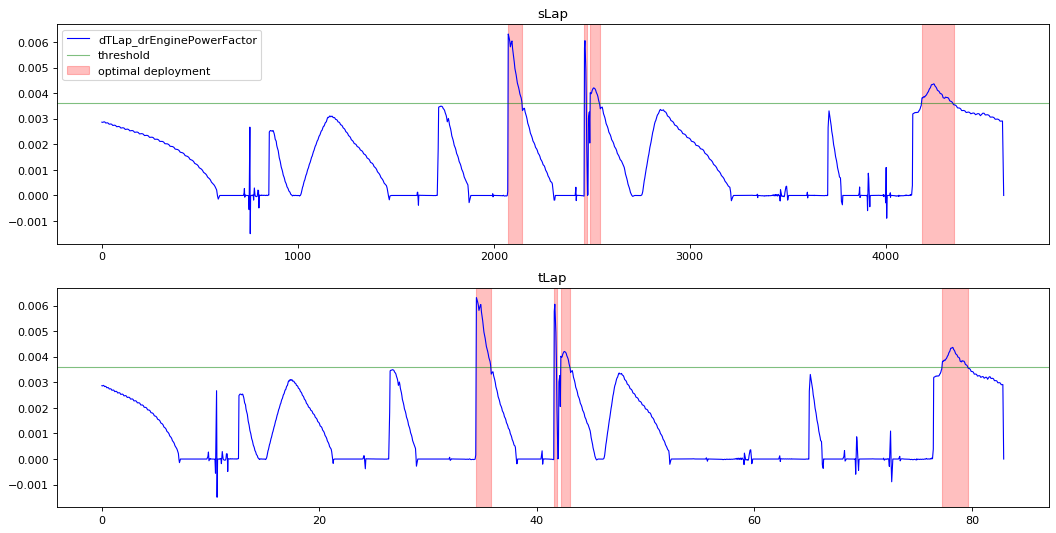

In [172]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), dpi=80)

for ax, x_name in zip(axs, ['sLap', 'tLap']):
    x = data[x_name]
    ax.set_title(x_name)
    ax.plot(x, data[sls_channel_name], 'b-', lw=1, label=sls_channel_name)

for ax in axs:
    ax.axhline(result.threshold, color='green', lw=1, alpha=0.5, label='threshold')

for ax, ranges in zip(axs, [result.sLap_ranges, result.tLap_ranges]):
    for i, range in enumerate(ranges):
        ax.axvspan(range[0], range[1], alpha=0.25, color='red', label='optimal deployment' if i == 0 else None)
    
axs[0].legend()
fig.show()